ToDo:
* HOw to plot using keras

In [1]:
%reset
%env MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
%env MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
env: MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
env: MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131


In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import matplotlib.pyplot as plt

import miscellaneous as msc

In [3]:
envname = "Reacher-v1"
expert_policy_file = "experts/" + envname + ".pkl"
render = True
num_rollouts = 5

In [4]:
policy = load_policy.load_policy(expert_policy_file);

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [5]:
input = tf.placeholder(tf.float32, shape=(1,11))
label = tf.placeholder(tf.float32, shape=(1,3))
dimensions = [11, 3]
pred = msc.neural_network(input, dimensions)

cost = tf.losses.mean_squared_error(label, pred)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

observations = []
actions = []
env = gym.make(envname)

[2017-09-21 10:55:05,148] Making new env: Reacher-v1


In [13]:
for i in range(num_rollouts):
    observations_rollout, actions_rollout = msc.rollout(env, policy, render)
    observations += observations_rollout
    actions += actions_rollout

Train policy

In [66]:
def baseline_model(input_dimension, output_dimension):
    model = Sequential()
    model.add(Dense(input_dimension/2, input_dim=input_dimension, init='normal', activation='relu'))
    model.add(Dense(output_dimension, init='normal'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [67]:
import random
from keras.models import Sequential
from keras.layers import Dense, Lambda

observations_array = np.array(observations)
input_dimension = observations_array.shape[1]
actions_array = np.array(actions)
output_dimension = actions_array.shape[2]

policy = baseline_model(input_dimension, output_dimension)
history = policy.fit(observations_array, actions_array.reshape(-1, output_dimension))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="normal", input_dim=11)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="normal")`
  after removing the cwd from sys.path.


Epoch 1/10
250/250 [==============================] - 0s - loss: 0.0080 - mean_absolute_error: 0.0515     
Epoch 2/10
250/250 [==============================] - 0s - loss: 0.0079 - mean_absolute_error: 0.0509     
Epoch 3/10
250/250 [==============================] - 0s - loss: 0.0078 - mean_absolute_error: 0.0504     
Epoch 4/10
250/250 [==============================] - 0s - loss: 0.0076 - mean_absolute_error: 0.0502     
Epoch 5/10
250/250 [==============================] - 0s - loss: 0.0075 - mean_absolute_error: 0.0500     
Epoch 6/10
250/250 [==============================] - 0s - loss: 0.0073 - mean_absolute_error: 0.0498     
Epoch 7/10
250/250 [==============================] - 0s - loss: 0.0072 - mean_absolute_error: 0.0496     
Epoch 8/10
250/250 [==============================] - 0s - loss: 0.0070 - mean_absolute_error: 0.0494     
Epoch 9/10
250/250 [==============================] - 0s - loss: 0.0068 - mean_absolute_error: 0.0493     
Epoch 10/10
250/250 [================

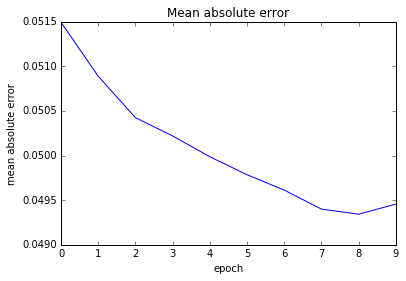

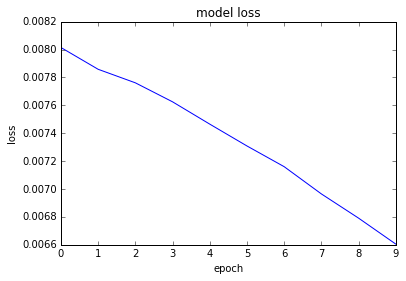

In [68]:
#  "Mean absolute error"
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [69]:
#predicted_actions = []
#for k in range(1):
#    for observation, action in zip(observations, actions):
#        train_step.run(feed_dict={input: observation, label: action})
#        pred_action = sess.run(pred, feed_dict={input: observation})
#        predicted_actions.append(pred_action)

In [70]:
#predicted_actions_array = np.array(predicted_actions)
#actual_actions_array = np.array(actions)
#evaluated_cost = np.sum(np.abs(actual_actions_array-predicted_actions_array),axis=2)

In [71]:
#plt.figure(figsize=(16,9))
#plt.plot(evaluated_cost)
#plt.show()

In [7]:
import tqdm

In [ ]:
returns = []
observations = []
actions = []
steps_numbers = []
max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
render = True

for i in tqdm.tqdm(range(num_rollouts)):
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = policy(obs[None, :])
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if render:
            env.render()
        if steps >= max_steps:
            break
    steps_numbers.append(steps)
    returns.append(totalr)

  0%|          | 0/5 [00:00<?, ?it/s]